Setup and Header

In [1]:
# Cell 1: Setup and Header
print("="*80)
print("🔍 INSURANCE RISK ANALYTICS - DATA QUALITY ASSESSMENT")
print("="*80)

# Import pandas first
import pandas as pd
from datetime import datetime

print("Notebook: 01_data_quality.ipynb")
print("Author: Insurance Analytics Team")
print("Date: " + datetime.now().strftime('%Y-%m-%d'))
print("\n" + "="*80)

🔍 INSURANCE RISK ANALYTICS - DATA QUALITY ASSESSMENT
Notebook: 01_data_quality.ipynb
Author: Insurance Analytics Team
Date: 2025-12-09



In [2]:
# Cell 2: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import json
from scipy import stats
import missingno as msno  # Optional: for advanced missing data visualization

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("✅ Libraries imported successfully")

# Check for optional libraries
try:
    import missingno
    MISSINGNO_AVAILABLE = True
    print("✅ missingno available for advanced visualizations")
except ImportError:
    MISSINGNO_AVAILABLE = False
    print("⚠️ missingno not installed. Install with: pip install missingno")

✅ Libraries imported successfully
✅ missingno available for advanced visualizations


In [3]:
# Cell 4: Load Real Cleaned Data
print("="*80)
print("📂 LOADING REAL CLEANED DATA")
print("="*80)

import os
import pandas as pd
from pathlib import Path

print(f"🔍 Looking for data files...")

# List possible file names (sometimes extensions differ)
possible_files = [
    "cleaned_data.txt",
    "cleaned_data.csv",
    "cleaned_data.parquet",
    "cleaned_data.pkl",
    "cleaned_data.feather",
    "cleaned_data.ftr",
    "cleaned_data",
]

# The base directory you mentioned
base_dir = Path(r"D:\10 acadamy\Insurance Risk Analytics & Predictive Modeling\data\01_interim")

# Check if the directory exists
if not base_dir.exists():
    print(f"❌ Directory not found: {base_dir}")
    
    # Show what's actually in D:\
    print(f"\n📂 Checking D:\\ drive structure...")
    d_drive = Path("D:/")
    if d_drive.exists():
        print(f"Contents of D:\\ (first 20 items):")
        items = list(d_drive.iterdir())
        for item in items[:20]:
            if item.is_dir():
                print(f"  📂 {item.name}/")
            else:
                size_mb = item.stat().st_size / (1024**2)
                print(f"  📄 {item.name} ({size_mb:.1f} MB)")
    else:
        print(f"❌ D:\\ drive not accessible")
    
    # Check current directory structure
    print(f"\n📂 Current directory structure:")
    current = Path.cwd()
    print(f"Current: {current}")
    
    # Walk up and show structure
    for i in range(3):  # Check current and 2 levels up
        check_dir = current.parents[i] if i > 0 else current
        print(f"\nLevel {i}: {check_dir}")
        if check_dir.exists():
            try:
                items = list(check_dir.iterdir())
                print(f"  Contains {len(items)} items")
                for item in items[:10]:  # Show first 10
                    if item.is_dir():
                        print(f"    📂 {item.name}/")
            except:
                pass
    
    raise FileNotFoundError(f"Directory not found: {base_dir}")

# Directory exists, show what's in it
print(f"✅ Directory exists: {base_dir}")
print(f"\n📂 Contents of {base_dir}:")

files_found = []
try:
    items = list(base_dir.iterdir())
    if not items:
        print("  (empty directory)")
    else:
        for item in items:
            if item.is_file():
                size_mb = item.stat().st_size / (1024**2)
                files_found.append((item.name, size_mb))
                print(f"  📄 {item.name} ({size_mb:.1f} MB)")
            else:
                print(f"  📂 {item.name}/")
except Exception as e:
    print(f"  Error reading directory: {e}")

# Look for cleaned data files
print(f"\n🔍 Searching for cleaned data files...")

cleaned_files = []
for filename, size_mb in files_found:
    # Look for files that might be our cleaned data
    if any(keyword in filename.lower() for keyword in ['clean', 'processed', 'interim', 'final']):
        cleaned_files.append((filename, size_mb))

if cleaned_files:
    print(f"Found {len(cleaned_files)} potential cleaned data files:")
    for filename, size_mb in cleaned_files:
        print(f"  • {filename} ({size_mb:.1f} MB)")
    
    # Try to load the largest file (likely the data file)
    cleaned_files.sort(key=lambda x: x[1], reverse=True)  # Sort by size, largest first
    
    file_to_load = base_dir / cleaned_files[0][0]
    print(f"\n📥 Attempting to load largest file: {file_to_load.name} ({cleaned_files[0][1]:.1f} MB)")
else:
    print(f"❌ No obvious cleaned data files found")
    
    # Try to find any data files
    data_files = [(name, size) for name, size in files_found if 
                  name.endswith('.csv') or name.endswith('.txt') or 
                  name.endswith('.parquet') or name.endswith('.pkl')]
    
    if data_files:
        print(f"\nFound {len(data_files)} data files (by extension):")
        for filename, size_mb in data_files:
            print(f"  • {filename} ({size_mb:.1f} MB)")
        
        # Load the largest one
        data_files.sort(key=lambda x: x[1], reverse=True)
        file_to_load = base_dir / data_files[0][0]
        print(f"\n📥 Attempting to load: {file_to_load.name}")
    else:
        print(f"\n❌ No data files found in directory")
        print("\n🔍 Please check:")
        print(f"1. The directory path: {base_dir}")
        print("2. That the file exists (maybe it's in a different location)")
        print("3. The actual file name (might be different than expected)")
        
        # Show parent directories
        print(f"\n📁 Parent directory ({base_dir.parent}):")
        try:
            parent_items = list(base_dir.parent.iterdir())
            for item in parent_items:
                if item.is_dir():
                    print(f"  📂 {item.name}/")
                else:
                    size_mb = item.stat().st_size / (1024**2)
                    print(f"  📄 {item.name} ({size_mb:.1f} MB)")
        except:
            pass
        
        raise FileNotFoundError(f"No data files found in {base_dir}")

# Function to load data based on file extension
def load_data_file(filepath, nrows=50000):
    """Load data file based on its extension"""
    print(f"\n📥 Loading {filepath.name}...")
    
    ext = filepath.suffix.lower()
    
    try:
        if ext == '.csv' or ext == '.txt':
            # Try CSV/TXT with various options
            for encoding in ['utf-8', 'latin-1', 'utf-8-sig', None]:
                try:
                    print(f"  Trying with encoding: {encoding if encoding else 'default'}")
                    df = pd.read_csv(
                        filepath, 
                        nrows=nrows,
                        encoding=encoding,
                        on_bad_lines='skip',
                        low_memory=False
                    )
                    print(f"    ✅ Success! Loaded {len(df):,} rows")
                    return df
                except Exception as e:
                    print(f"    ❌ Failed: {str(e)[:80]}")
            
            # Last resort: try with engine='python'
            print(f"  Trying with engine='python'...")
            df = pd.read_csv(filepath, nrows=nrows, engine='python', on_bad_lines='skip')
            print(f"    ✅ Success! Loaded {len(df):,} rows")
            return df
            
        elif ext == '.parquet':
            df = pd.read_parquet(filepath)
            if nrows:
                df = df.head(nrows)
            print(f"✅ Loaded {len(df):,} rows")
            return df
            
        elif ext == '.pkl':
            df = pd.read_pickle(filepath)
            if nrows:
                df = df.head(nrows)
            print(f"✅ Loaded {len(df):,} rows")
            return df
            
        elif ext == '.feather' or ext == '.ftr':
            df = pd.read_feather(filepath)
            if nrows:
                df = df.head(nrows)
            print(f"✅ Loaded {len(df):,} rows")
            return df
            
        else:
            # Try as CSV for unknown extensions
            print(f"  Unknown extension {ext}, trying as CSV...")
            df = pd.read_csv(filepath, nrows=nrows, on_bad_lines='skip')
            print(f"    ✅ Success! Loaded {len(df):,} rows")
            return df
            
    except Exception as e:
        print(f"❌ Error loading {filepath.name}: {e}")
        return None

# Load the data
df = load_data_file(file_to_load, nrows=50000)

if df is None:
    print(f"\n❌ Could not load {file_to_load.name}")
    print("\n🔍 Checking file format...")
    
    # Read first few lines
    try:
        with open(file_to_load, 'r', encoding='utf-8', errors='ignore') as f:
            lines = [next(f) for _ in range(5)]
        
        print("First 5 lines of file:")
        for i, line in enumerate(lines, 1):
            # Clean and display
            line_display = line[:200].replace('\t', '\\t').replace('\r', '\\r').replace('\n', '\\n')
            print(f"  Line {i}: {line_display}")
            
        # Try to guess delimiter
        if lines:
            first_line = lines[0]
            delimiters = {
                ',': first_line.count(','),
                '\t': first_line.count('\t'),
                ';': first_line.count(';'),
                '|': first_line.count('|'),
                ' ': first_line.count(' ') - first_line.count('  ')  # Approximate single spaces
            }
            print(f"\n📊 Delimiter counts in first line:")
            for delim, count in delimiters.items():
                if delim == '\t':
                    print(f"  Tab (\\t): {count}")
                elif delim == ' ':
                    print(f"  Space: {count}")
                else:
                    print(f"  {delim}: {count}")
                    
    except Exception as e:
        print(f"Could not read file: {e}")
    
    raise ValueError(f"Could not load data from {file_to_load}")

# Successfully loaded
print("\n" + "="*80)
print(f"✅ DATA LOADED SUCCESSFULLY")
print("="*80)

print(f"\n📊 Dataset Summary:")
print(f"• File: {file_to_load.name}")
print(f"• Rows loaded: {df.shape[0]:,}")
print(f"• Columns: {df.shape[1]}")
print(f"• Memory: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

print(f"\n📈 Column Types:")
for dtype, count in df.dtypes.value_counts().items():
    print(f"  • {str(dtype):<15}: {count} columns")

print(f"\n🔍 First 10 columns:")
for i, col in enumerate(df.columns[:10], 1):
    dtype = str(df[col].dtype)
    unique = df[col].nunique()
    print(f"  {i:2d}. {col:<25} [{dtype:<10}] Unique: {unique:,}")

print(f"\n📋 Sample (first 3 rows):")
print(df.head(3).to_string(max_cols=10, max_rows=3))

print(f"\n💾 Data loaded and ready for analysis!")

📂 LOADING REAL CLEANED DATA
🔍 Looking for data files...
✅ Directory exists: D:\10 acadamy\Insurance Risk Analytics & Predictive Modeling\data\01_interim

📂 Contents of D:\10 acadamy\Insurance Risk Analytics & Predictive Modeling\data\01_interim:
  📄 .gitignore (0.0 MB)
  📄 cleaned_data.csv (506.5 MB)
  📄 features_data.csv (529.5 MB)
  📄 raw_data.csv (497.1 MB)

🔍 Searching for cleaned data files...
Found 1 potential cleaned data files:
  • cleaned_data.csv (506.5 MB)

📥 Attempting to load largest file: cleaned_data.csv (506.5 MB)

📥 Loading cleaned_data.csv...
  Trying with encoding: utf-8
    ✅ Success! Loaded 50,000 rows

✅ DATA LOADED SUCCESSFULLY

📊 Dataset Summary:
• File: cleaned_data.csv
• Rows loaded: 50,000
• Columns: 52
• Memory: 115.8 MB

📈 Column Types:
  • object         : 34 columns
  • float64        : 13 columns
  • int64          : 4 columns
  • bool           : 1 columns

🔍 First 10 columns:
   1. UnderwrittenCoverID       [int64     ] Unique: 8,882
   2. PolicyID    

In [4]:
# Cell 5: Data Quality Analyzer Class Definition and Analysis

class DataQualityAnalyzer:
    """Comprehensive data quality analysis tool"""
    
    def __init__(self, df):
        self.df = df
        self.issues = []
        self.metrics = {}
    
    def _add_issue(self, severity, message):
        """Add an issue to the tracker"""
        self.issues.append((severity, message))
    
    def analyze_completeness(self):
        """Analyze completeness of data"""
        completeness = {}
        
        # Overall completeness
        total_cells = self.df.shape[0] * self.df.shape[1]
        missing_cells = self.df.isnull().sum().sum()
        completeness_rate = ((total_cells - missing_cells) / total_cells) * 100
        
        completeness['overall_completeness'] = completeness_rate
        completeness['missing_cells'] = int(missing_cells)
        completeness['total_cells'] = int(total_cells)
        
        # Column-wise completeness
        col_completeness = {}
        for col in self.df.columns:
            missing = self.df[col].isnull().sum()
            pct_missing = (missing / len(self.df)) * 100
            col_completeness[col] = {
                'missing_count': int(missing),
                'missing_pct': pct_missing,
                'completeness_pct': 100 - pct_missing
            }
            
            # Flag issues
            if pct_missing > 50:
                self._add_issue('HIGH', f"Column '{col}' has {pct_missing:.1f}% missing values")
            elif pct_missing > 20:
                self._add_issue('MEDIUM', f"Column '{col}' has {pct_missing:.1f}% missing values")
            elif pct_missing > 5:
                self._add_issue('LOW', f"Column '{col}' has {pct_missing:.1f}% missing values")
        
        completeness['columns'] = col_completeness
        
        # Rows with missing values
        rows_with_missing = self.df.isnull().any(axis=1).sum()
        completeness['rows_with_missing'] = int(rows_with_missing)
        completeness['rows_missing_pct'] = (rows_with_missing / len(self.df)) * 100
        
        return completeness
    
    def analyze_consistency(self):
        """Analyze data consistency"""
        consistency = {}
        
        # Data type consistency
        dtype_counts = {}
        for col in self.df.columns:
            dtype = str(self.df[col].dtype)
            if dtype not in dtype_counts:
                dtype_counts[dtype] = 0
            dtype_counts[dtype] += 1
        
        consistency['dtype_distribution'] = dtype_counts
        
        # Check for mixed types in object columns
        mixed_type_cols = []
        for col in self.df.select_dtypes(include=['object']).columns:
            try:
                # Try to convert to numeric to check for mixed types
                numeric_converted = pd.to_numeric(self.df[col], errors='coerce')
                if numeric_converted.notna().any() and self.df[col].notna().any():
                    # Some values converted, some didn't - potential mixed types
                    pct_numeric = numeric_converted.notna().sum() / len(self.df) * 100
                    if 10 < pct_numeric < 90:  # Mixed types
                        mixed_type_cols.append(col)
                        self._add_issue('MEDIUM', f"Column '{col}' appears to have mixed data types")
            except:
                pass
        
        consistency['mixed_type_columns'] = mixed_type_cols
        
        # Check for inconsistent categorical values
        categorical_issues = []
        for col in self.df.select_dtypes(include=['object']).columns:
            if self.df[col].nunique() < 100:  # Only check columns with reasonable number of categories
                values = self.df[col].dropna().astype(str)
                # Check for case inconsistencies
                lower_values = values.str.lower()
                unique_lower = lower_values.nunique()
                unique_original = values.nunique()
                
                if unique_lower < unique_original * 0.9:  # Significant case differences
                    categorical_issues.append(col)
                    self._add_issue('LOW', f"Column '{col}' has case inconsistencies")
        
        consistency['categorical_issues'] = categorical_issues
        
        return consistency
    
    def analyze_uniqueness(self):
        """Analyze uniqueness of data"""
        uniqueness = {}
        
        # Duplicate rows
        duplicate_rows = self.df.duplicated().sum()
        uniqueness['duplicate_rows'] = int(duplicate_rows)
        uniqueness['duplicate_pct'] = (duplicate_rows / len(self.df)) * 100
        
        if duplicate_rows > 0:
            self._add_issue('MEDIUM', f"Found {duplicate_rows:,} duplicate rows ({uniqueness['duplicate_pct']:.1f}%)")
        
        # Column uniqueness
        column_uniqueness = {}
        for col in self.df.columns:
            unique_count = self.df[col].nunique()
            pct_unique = (unique_count / len(self.df)) * 100
            column_uniqueness[col] = {
                'unique_count': int(unique_count),
                'unique_pct': pct_unique
            }
            
            # Flag issues
            if pct_unique > 99.9 and len(self.df) > 1000:
                self._add_issue('INFO', f"Column '{col}' is nearly unique (like an ID)")
            elif pct_unique < 1 and len(self.df) > 100:
                self._add_issue('MEDIUM', f"Column '{col}' has very low uniqueness ({pct_unique:.1f}%)")
        
        uniqueness['columns'] = column_uniqueness
        
        # Potential key columns
        potential_keys = []
        for col in self.df.columns:
            if self.df[col].nunique() == len(self.df) and self.df[col].notna().all():
                potential_keys.append(col)
        
        uniqueness['potential_key_columns'] = potential_keys
        
        return uniqueness
    
    def analyze_validity(self):
        """Analyze data validity based on common sense rules"""
        validity = {'issues': []}
        
        # Check for negative values in columns that shouldn't be negative
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if self.df[col].min() < 0:
                # Check if this could be valid (like temperature, returns, etc.)
                col_lower = col.lower()
                if not any(term in col_lower for term in ['temp', 'return', 'change', 'difference', 'delta', 'profit', 'loss']):
                    negative_count = (self.df[col] < 0).sum()
                    if negative_count > 0:
                        validity['issues'].append(f"Negative values in '{col}': {negative_count:,}")
                        self._add_issue('MEDIUM', f"Column '{col}' has {negative_count:,} negative values")
        
        # Check for extreme outliers (beyond 5 standard deviations)
        for col in numeric_cols:
            if self.df[col].nunique() > 10:  # Skip binary/ categorical numeric
                z_scores = np.abs((self.df[col] - self.df[col].mean()) / self.df[col].std())
                extreme_outliers = (z_scores > 5).sum()
                if extreme_outliers > 0:
                    validity['issues'].append(f"Extreme outliers in '{col}': {extreme_outliers:,}")
                    self._add_issue('LOW', f"Column '{col}' has {extreme_outliers:,} extreme outliers")
        
        # Check date validity (if date columns exist)
        date_cols = self.df.select_dtypes(include=['datetime64']).columns
        for col in date_cols:
            # Check for future dates (if that doesn't make sense)
            if col.lower() not in ['forecast', 'prediction', 'target']:
                future_dates = (self.df[col] > pd.Timestamp.now()).sum()
                if future_dates > 0:
                    validity['issues'].append(f"Future dates in '{col}': {future_dates:,}")
                    self._add_issue('MEDIUM', f"Column '{col}' has {future_dates:,} future dates")
        
        return validity
    
    def calculate_quality_score(self, metrics):
        """Calculate overall quality score"""
        scores = {}
        
        # Completeness score (40% weight)
        completeness = metrics['completeness']['overall_completeness']
        scores['completeness'] = completeness
        
        # Uniqueness score (30% weight)
        duplicate_pct = metrics['uniqueness']['duplicate_pct']
        uniqueness_score = max(0, 100 - duplicate_pct * 2)  # Penalize duplicates
        scores['uniqueness'] = uniqueness_score
        
        # Consistency score (20% weight)
        # Simplified - based on number of issues
        consistency_issues = len(metrics['consistency'].get('mixed_type_columns', [])) + \
                            len(metrics['consistency'].get('categorical_issues', []))
        consistency_score = max(0, 100 - consistency_issues * 10)
        scores['consistency'] = consistency_score
        
        # Validity score (10% weight)
        validity_issues = len(metrics['validity'].get('issues', []))
        validity_score = max(0, 100 - validity_issues * 15)
        scores['validity'] = validity_score
        
        # Weighted overall score
        weights = {'completeness': 0.4, 'uniqueness': 0.3, 'consistency': 0.2, 'validity': 0.1}
        overall_score = sum(scores[dim] * weights[dim] for dim in scores)
        
        # Determine rating
        if overall_score >= 90:
            rating = "EXCELLENT"
        elif overall_score >= 80:
            rating = "GOOD"
        elif overall_score >= 70:
            rating = "FAIR"
        elif overall_score >= 60:
            rating = "POOR"
        else:
            rating = "CRITICAL"
        
        return {
            'overall_score': overall_score,
            'rating': rating,
            'dimension_scores': scores
        }
    
    def generate_report(self):
        """Generate comprehensive data quality report"""
        print("📊 Analyzing completeness...")
        completeness = self.analyze_completeness()
        
        print("📈 Analyzing consistency...")
        consistency = self.analyze_consistency()
        
        print("🔍 Analyzing uniqueness...")
        uniqueness = self.analyze_uniqueness()
        
        print("✅ Analyzing validity...")
        validity = self.analyze_validity()
        
        # Calculate quality score
        metrics = {
            'completeness': completeness,
            'consistency': consistency,
            'uniqueness': uniqueness,
            'validity': validity
        }
        
        quality_score = self.calculate_quality_score(metrics)
        
        # Combine all metrics
        report = {
            'dataset_info': {
                'rows': len(self.df),
                'columns': len(self.df.columns),
                'memory_mb': self.df.memory_usage(deep=True).sum() / 1024**2
            },
            'metrics': metrics,
            'quality_score': quality_score,
            'issues': self.issues
        }
        
        return report

print("="*80)
print("🔬 INITIALIZING DATA QUALITY ANALYZER")
print("="*80)

# Import required libraries
import numpy as np
import pandas as pd

# Initialize analyzer
analyzer = DataQualityAnalyzer(df)

# Run comprehensive analysis
print("\n🚀 Running data quality analysis...")
metrics = analyzer.generate_report()

print("\n" + "="*80)
print("📋 ANALYSIS COMPLETE - SUMMARY")
print("="*80)

# Display key findings
print(f"📊 Dataset: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"📈 Overall Quality Score: {metrics['quality_score']['overall_score']:.1f}/100")
print(f"🏆 Rating: {metrics['quality_score']['rating']}")

print(f"\n🚨 Issues Found: {len(analyzer.issues)}")
issues_by_severity = {'CRITICAL': 0, 'HIGH': 0, 'MEDIUM': 0, 'LOW': 0, 'INFO': 0}
for severity, issue in analyzer.issues:
    if severity in issues_by_severity:
        issues_by_severity[severity] += 1

for severity in ['CRITICAL', 'HIGH', 'MEDIUM', 'LOW', 'INFO']:
    count = issues_by_severity[severity]
    if count > 0:
        print(f"   {severity}: {count} issues")

# Show top 5 most important issues
print(f"\n🔝 Top 5 Issues:")
top_issues = [issue for issue in analyzer.issues if issue[0] in ['CRITICAL', 'HIGH', 'MEDIUM']]
for i, (severity, issue) in enumerate(top_issues[:5], 1):
    print(f"   {i}. [{severity}] {issue}")

# Display dimension scores
print(f"\n📊 Dimension Scores:")
for dimension, score in metrics['quality_score']['dimension_scores'].items():
    print(f"   • {dimension.capitalize()}: {score:.1f}/100")

# Key statistics
print(f"\n📈 Key Statistics:")
print(f"   • Missing Values: {metrics['metrics']['completeness']['missing_cells']:,} "
      f"({metrics['metrics']['completeness']['overall_completeness']:.1f}% complete)")
print(f"   • Duplicate Rows: {metrics['metrics']['uniqueness']['duplicate_rows']:,} "
      f"({metrics['metrics']['uniqueness']['duplicate_pct']:.1f}%)")
print(f"   • Mixed Type Columns: {len(metrics['metrics']['consistency'].get('mixed_type_columns', []))}")
print(f"   • Potential Key Columns: {len(metrics['metrics']['uniqueness'].get('potential_key_columns', []))}")

print(f"\n✅ Data quality analysis complete!")

🔬 INITIALIZING DATA QUALITY ANALYZER

🚀 Running data quality analysis...
📊 Analyzing completeness...
📈 Analyzing consistency...
🔍 Analyzing uniqueness...
✅ Analyzing validity...

📋 ANALYSIS COMPLETE - SUMMARY
📊 Dataset: 50,000 rows × 52 columns
📈 Overall Quality Score: 87.1/100
🏆 Rating: GOOD

🚨 Issues Found: 62
   HIGH: 5 issues
   MEDIUM: 48 issues
   LOW: 9 issues

🔝 Top 5 Issues:
   1. [HIGH] Column 'WrittenOff' has 54.9% missing values
   2. [HIGH] Column 'Rebuilt' has 54.9% missing values
   3. [HIGH] Column 'Converted' has 54.9% missing values
   4. [HIGH] Column 'CrossBorder' has 100.0% missing values
   5. [HIGH] Column 'NumberOfVehiclesInFleet' has 100.0% missing values

📊 Dimension Scores:
   • Completeness: 92.8/100
   • Uniqueness: 100.0/100
   • Consistency: 100.0/100
   • Validity: 0.0/100

📈 Key Statistics:
   • Missing Values: 187,229 (92.8% complete)
   • Duplicate Rows: 0 (0.0%)
   • Mixed Type Columns: 0
   • Potential Key Columns: 0

✅ Data quality analysis complet

📊 VISUALIZING MISSING DATA PATTERNS


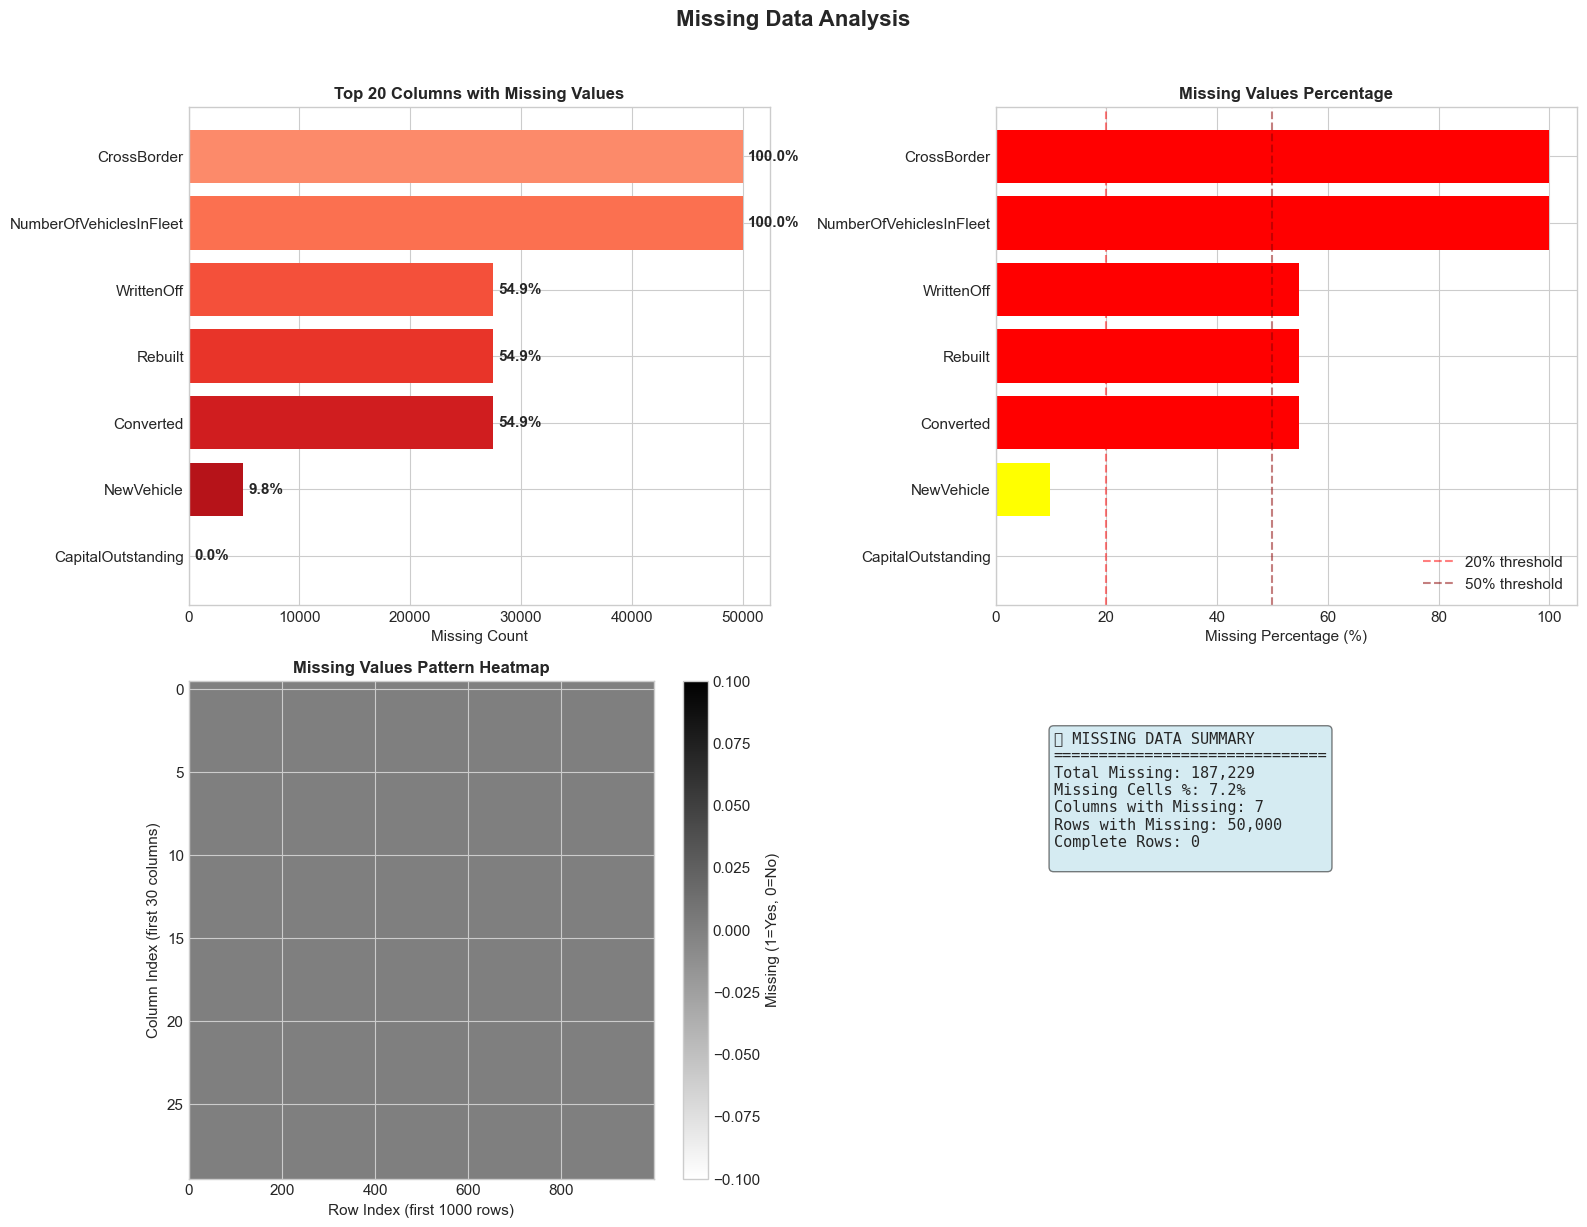

In [5]:
# Cell 6: Visualize Missing Data Patterns
print("="*80)
print("📊 VISUALIZING MISSING DATA PATTERNS")
print("="*80)

# Create visualization figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Missing Data Analysis', fontsize=16, fontweight='bold', y=1.02)

# 1. Missing values by column (top 20)
missing_by_col = df.isnull().sum().sort_values(ascending=False)
missing_top20 = missing_by_col[missing_by_col > 0].head(20)

if len(missing_top20) > 0:
    bars = axes[0, 0].barh(range(len(missing_top20)), missing_top20.values, 
                          color=plt.cm.Reds(np.linspace(0.4, 0.9, len(missing_top20))))
    axes[0, 0].set_yticks(range(len(missing_top20)))
    axes[0, 0].set_yticklabels(missing_top20.index)
    axes[0, 0].set_xlabel('Missing Count')
    axes[0, 0].set_title('Top 20 Columns with Missing Values', fontsize=12, fontweight='bold')
    axes[0, 0].invert_yaxis()
    
    # Add percentage labels
    for i, (col, count) in enumerate(missing_top20.items()):
        pct = (count / len(df)) * 100
        axes[0, 0].text(count + max(missing_top20.values)*0.01, i, 
                       f'{pct:.1f}%', va='center', fontweight='bold')
else:
    axes[0, 0].text(0.5, 0.5, 'No Missing Values Found', 
                   ha='center', va='center', fontsize=12, fontweight='bold', color='green')

# 2. Missing values percentage distribution
missing_pct_by_col = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
missing_pct_top20 = missing_pct_by_col[missing_pct_by_col > 0].head(20)

if len(missing_pct_top20) > 0:
    colors = ['red' if pct > 50 else 'orange' if pct > 20 else 'yellow' for pct in missing_pct_top20.values]
    axes[0, 1].barh(range(len(missing_pct_top20)), missing_pct_top20.values, color=colors)
    axes[0, 1].set_yticks(range(len(missing_pct_top20)))
    axes[0, 1].set_yticklabels(missing_pct_top20.index)
    axes[0, 1].set_xlabel('Missing Percentage (%)')
    axes[0, 1].set_title('Missing Values Percentage', fontsize=12, fontweight='bold')
    axes[0, 1].invert_yaxis()
    axes[0, 1].axvline(x=20, color='red', linestyle='--', alpha=0.5, label='20% threshold')
    axes[0, 1].axvline(x=50, color='darkred', linestyle='--', alpha=0.5, label='50% threshold')
    axes[0, 1].legend()
else:
    axes[0, 1].text(0.5, 0.5, 'No Missing Values', 
                   ha='center', va='center', fontsize=12, fontweight='bold', color='green')

# 3. Missing data heatmap (first 1000 rows, first 30 columns)
try:
    missing_matrix = df.isnull().astype(int).iloc[:1000, :30]
    im = axes[1, 0].imshow(missing_matrix.T, cmap='binary', aspect='auto', interpolation='nearest')
    axes[1, 0].set_xlabel('Row Index (first 1000 rows)')
    axes[1, 0].set_ylabel('Column Index (first 30 columns)')
    axes[1, 0].set_title('Missing Values Pattern Heatmap', fontsize=12, fontweight='bold')
    plt.colorbar(im, ax=axes[1, 0], label='Missing (1=Yes, 0=No)')
except:
    axes[1, 0].text(0.5, 0.5, 'Could not create heatmap', 
                   ha='center', va='center', fontsize=12)

# 4. Missing data summary
summary_data = {
    'Total Missing': df.isnull().sum().sum(),
    'Missing Cells %': (df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100),
    'Columns with Missing': (df.isnull().sum() > 0).sum(),
    'Rows with Missing': df.isnull().any(axis=1).sum(),
    'Complete Rows': (~df.isnull().any(axis=1)).sum()
}

axes[1, 1].axis('off')
summary_text = "📊 MISSING DATA SUMMARY\n" + "="*30 + "\n"
for key, value in summary_data.items():
    if '%' in key:
        summary_text += f"{key}: {value:.1f}%\n"
    else:
        summary_text += f"{key}: {value:,}\n"

axes[1, 1].text(0.1, 0.9, summary_text, fontsize=11, fontfamily='monospace',
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()

🔍 VISUALIZING DUPLICATES AND UNIQUENESS


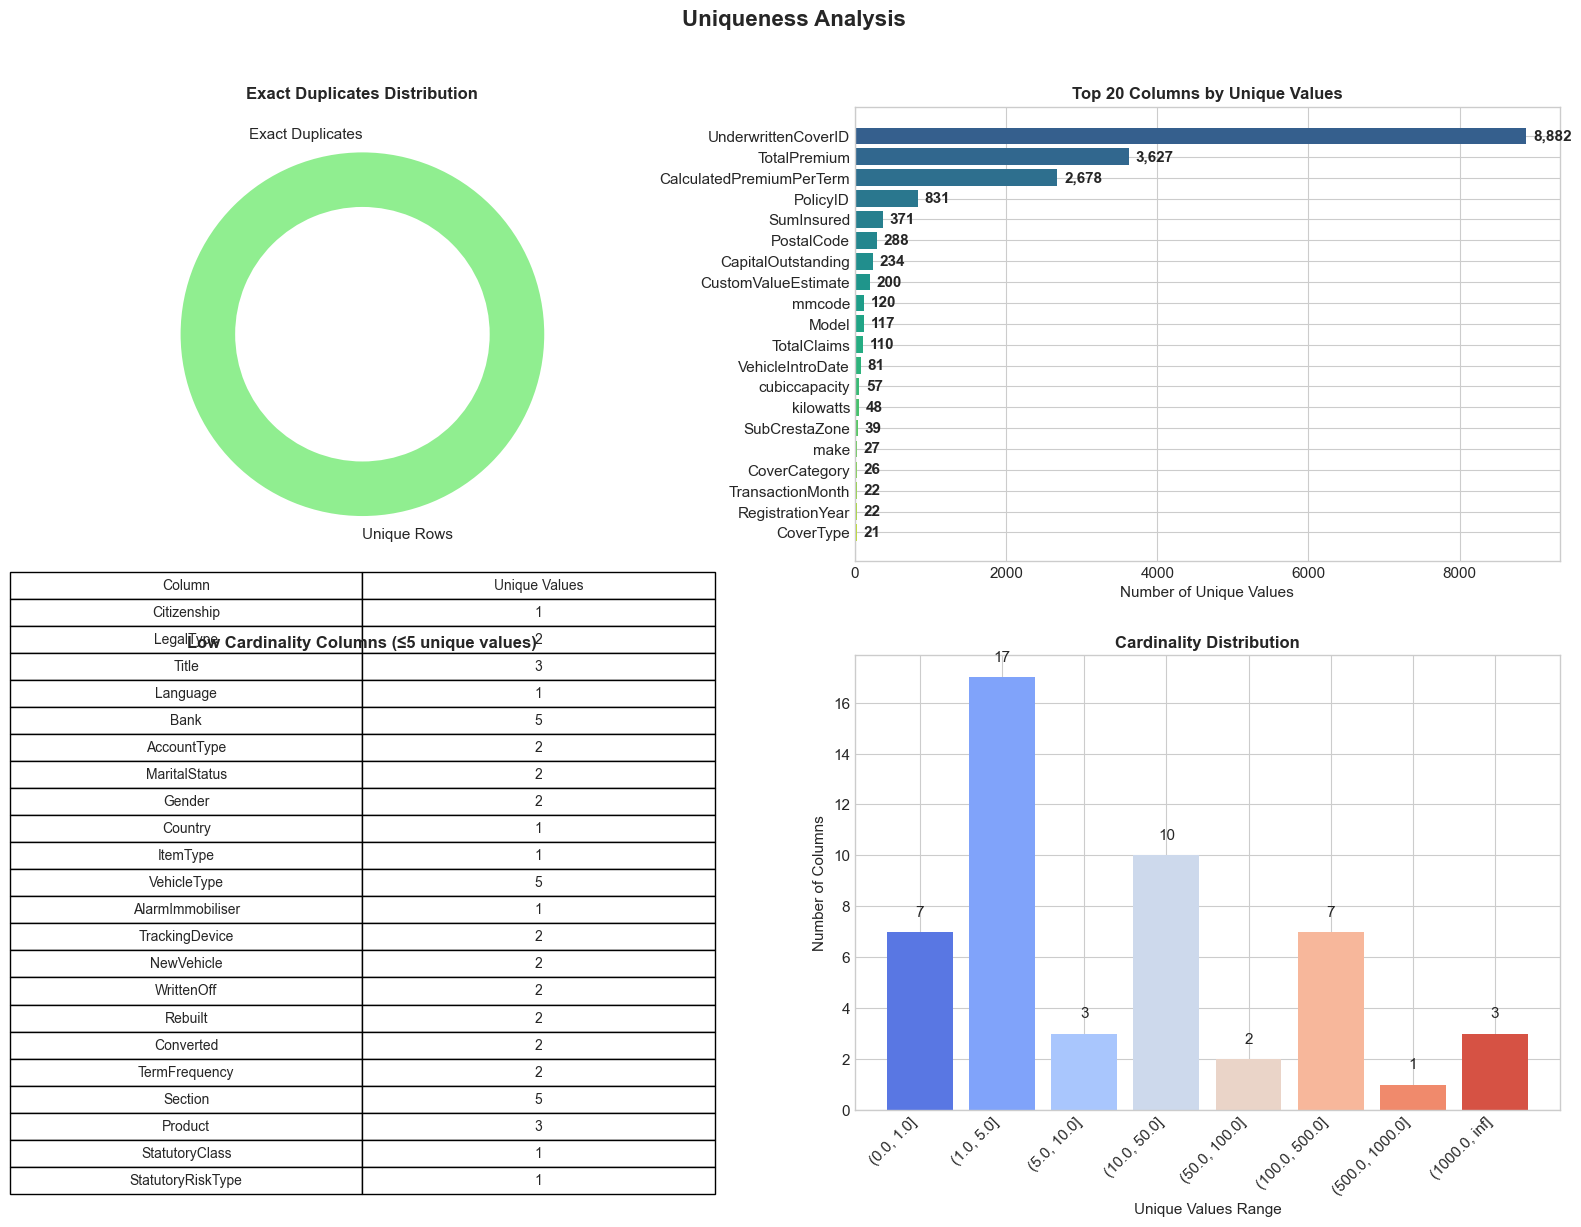

In [6]:
# Cell 7: Visualize Duplicates and Uniqueness
print("="*80)
print("🔍 VISUALIZING DUPLICATES AND UNIQUENESS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Uniqueness Analysis', fontsize=16, fontweight='bold', y=1.02)

# 1. Exact duplicates summary
exact_duplicates = df.duplicated().sum()
duplicate_pct = (exact_duplicates / len(df)) * 100

# Create donut chart for duplicates
sizes = [len(df) - exact_duplicates, exact_duplicates]
labels = ['Unique Rows', 'Exact Duplicates']
colors = ['lightgreen', 'lightcoral']
wedges, texts, autotexts = axes[0, 0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
                                         startangle=90, wedgeprops=dict(width=0.3))
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
axes[0, 0].set_title('Exact Duplicates Distribution', fontsize=12, fontweight='bold')

# 2. Unique values per column (top 20)
unique_counts = df.nunique().sort_values(ascending=False).head(20)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(unique_counts)))
bars = axes[0, 1].barh(range(len(unique_counts)), unique_counts.values, color=colors)
axes[0, 1].set_yticks(range(len(unique_counts)))
axes[0, 1].set_yticklabels(unique_counts.index)
axes[0, 1].set_xlabel('Number of Unique Values')
axes[0, 1].set_title('Top 20 Columns by Unique Values', fontsize=12, fontweight='bold')
axes[0, 1].invert_yaxis()

# Add value labels
for bar, value in zip(bars, unique_counts.values):
    axes[0, 1].text(bar.get_width() + max(unique_counts.values)*0.01, 
                   bar.get_y() + bar.get_height()/2, 
                   f'{int(value):,}', va='center', fontweight='bold')

# 3. Low cardinality columns (≤5 unique values)
categorical_cols = df.select_dtypes(include=['object']).columns
low_cardinality = {}
for col in categorical_cols:
    unique_count = df[col].nunique()
    if unique_count <= 5:
        low_cardinality[col] = unique_count

if low_cardinality:
    low_card_df = pd.DataFrame(list(low_cardinality.items()), columns=['Column', 'Unique Values'])
    axes[1, 0].axis('tight')
    axes[1, 0].axis('off')
    table = axes[1, 0].table(cellText=low_card_df.values,
                            colLabels=low_card_df.columns,
                            cellLoc='center',
                            loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    axes[1, 0].set_title('Low Cardinality Columns (≤5 unique values)', fontsize=12, fontweight='bold')
else:
    axes[1, 0].text(0.5, 0.5, 'No low cardinality columns found', 
                   ha='center', va='center', fontsize=12, fontweight='bold')

# 4. Cardinality distribution
cardinality_bins = pd.cut(df.nunique(), bins=[0, 1, 5, 10, 50, 100, 500, 1000, float('inf')])
cardinality_counts = cardinality_bins.value_counts().sort_index()

x_pos = range(len(cardinality_counts))
bars = axes[1, 1].bar(x_pos, cardinality_counts.values, color=plt.cm.coolwarm(np.linspace(0.1, 0.9, len(cardinality_counts))))
axes[1, 1].set_xlabel('Unique Values Range')
axes[1, 1].set_ylabel('Number of Columns')
axes[1, 1].set_title('Cardinality Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels([str(c) for c in cardinality_counts.index], rotation=45, ha='right')

# Add value labels
for bar, count in zip(bars, cardinality_counts.values):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{int(count)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

🎯 VISUALIZING OUTLIERS AND ACCURACY ISSUES


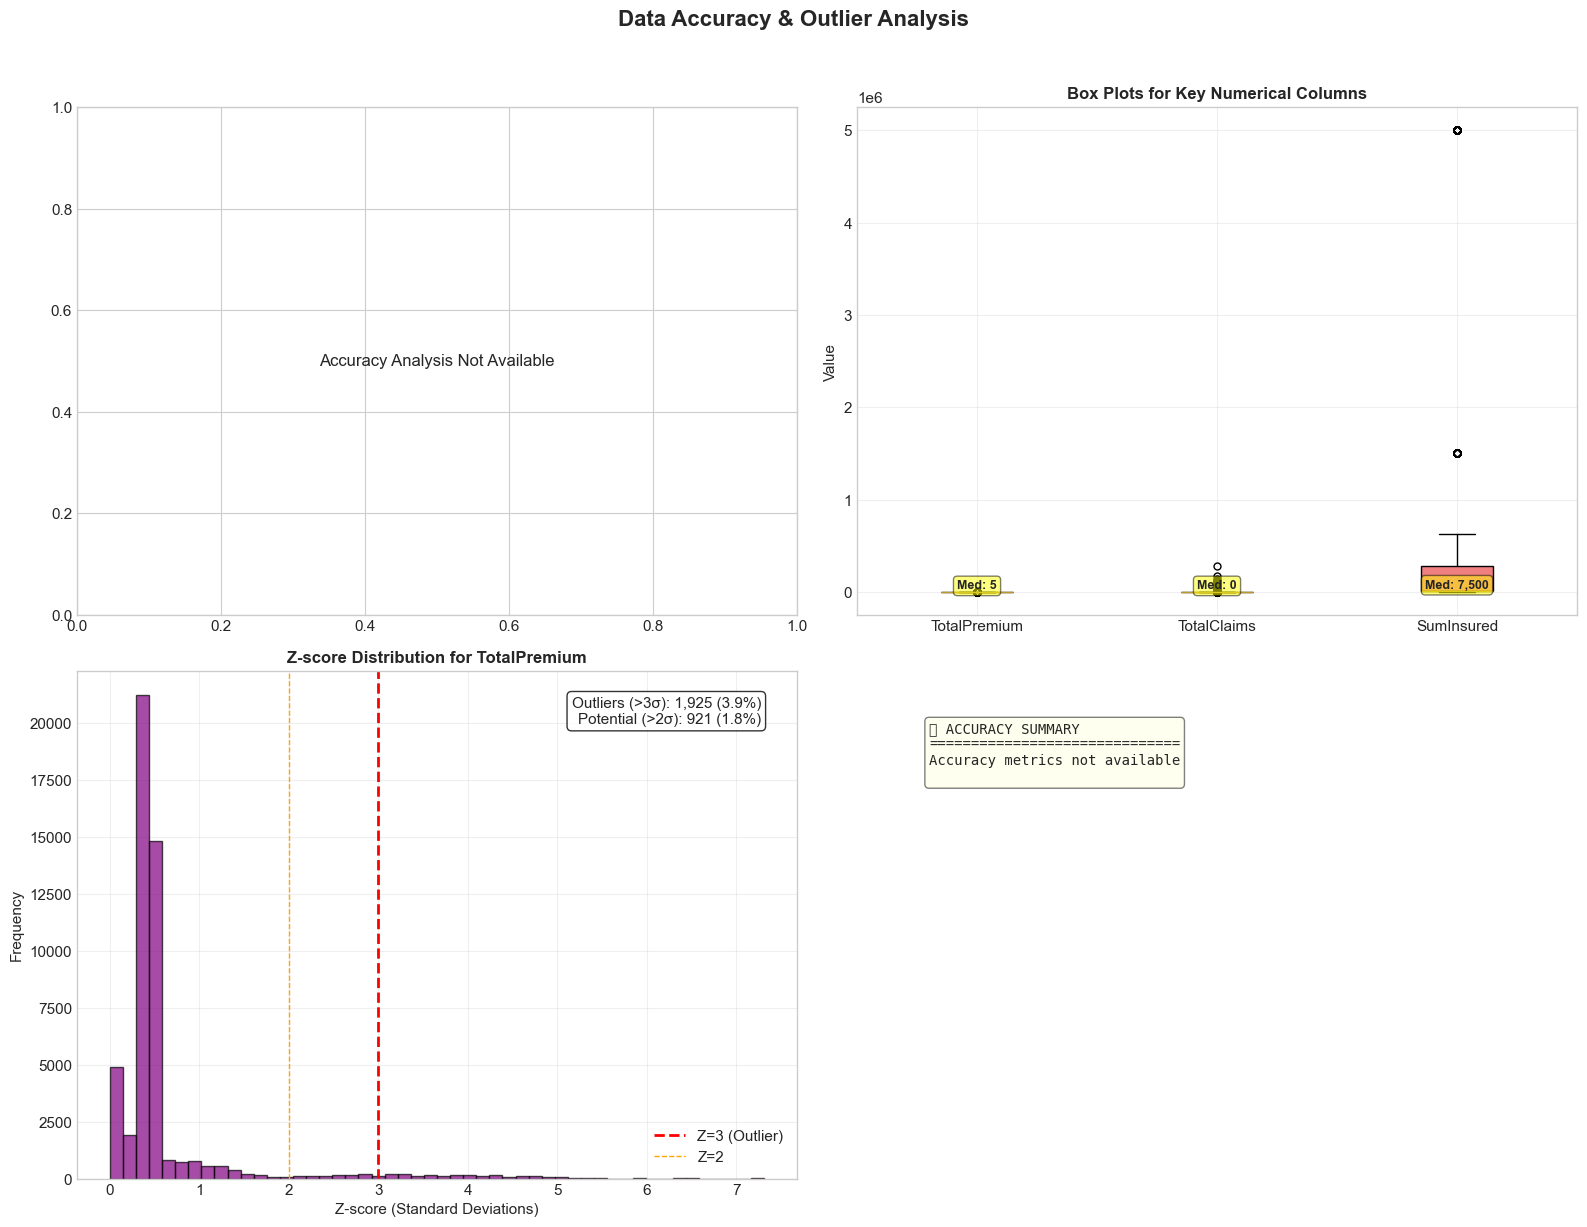

In [7]:
# Cell 9: Visualize Outliers and Accuracy Issues
print("="*80)
print("🎯 VISUALIZING OUTLIERS AND ACCURACY ISSUES")
print("="*80)

# Create visualization figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Data Accuracy & Outlier Analysis', fontsize=16, fontweight='bold', y=1.02)

# 1. Outlier summary for key columns
if 'accuracy' in metrics and 'outliers_summary' in metrics['accuracy']:
    outliers_data = metrics['accuracy']['outliers_summary']
    
    if outliers_data:
        # Prepare data for visualization
        columns = list(outliers_data.keys())[:8]  # Show first 8 columns
        outlier_counts = [outliers_data[col]['outlier_count'] for col in columns]
        outlier_pcts = [outliers_data[col]['outlier_pct'] for col in columns]
        
        x = np.arange(len(columns))
        width = 0.35
        
        # Create dual-axis plot
        ax1 = axes[0, 0]
        bars1 = ax1.bar(x - width/2, outlier_counts, width, label='Outlier Count', color='lightcoral')
        ax1.set_xlabel('Columns')
        ax1.set_ylabel('Outlier Count', color='darkred')
        ax1.tick_params(axis='y', labelcolor='darkred')
        ax1.set_xticks(x)
        ax1.set_xticklabels(columns, rotation=45, ha='right')
        ax1.set_title('Outlier Analysis by Column', fontsize=12, fontweight='bold')
        
        # Second y-axis for percentage
        ax2 = ax1.twinx()
        bars2 = ax2.bar(x + width/2, outlier_pcts, width, label='Outlier %', color='lightblue', alpha=0.7)
        ax2.set_ylabel('Outlier Percentage (%)', color='darkblue')
        ax2.tick_params(axis='y', labelcolor='darkblue')
        
        # Add legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
        
        # Add threshold lines
        ax2.axhline(y=10, color='red', linestyle='--', alpha=0.5, linewidth=1)
        ax2.axhline(y=5, color='orange', linestyle='--', alpha=0.5, linewidth=1)
        
        # Add value labels
        for i, (count, pct) in enumerate(zip(outlier_counts, outlier_pcts)):
            ax1.text(i - width/2, count + max(outlier_counts)*0.01, f'{count:,}', 
                    ha='center', va='bottom', fontsize=9)
            ax2.text(i + width/2, pct + max(outlier_pcts)*0.01, f'{pct:.1f}%', 
                    ha='center', va='bottom', fontsize=9)
    else:
        axes[0, 0].text(0.5, 0.5, 'No Outlier Analysis Available', 
                       ha='center', va='center', fontsize=12)
else:
    axes[0, 0].text(0.5, 0.5, 'Accuracy Analysis Not Available', 
                   ha='center', va='center', fontsize=12)

# 2. Box plots for key numerical columns
key_numeric_cols = ['TotalPremium', 'TotalClaims', 'SumInsured']
available_cols = [col for col in key_numeric_cols if col in df.columns]

if len(available_cols) >= 2:
    # Create box plots
    data_to_plot = [df[col].dropna() for col in available_cols]
    
    bp = axes[0, 1].boxplot(data_to_plot, patch_artist=True, labels=available_cols,
                           showfliers=True, flierprops=dict(marker='o', markersize=5))
    
    # Color boxes
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors[:len(available_cols)]):
        patch.set_facecolor(color)
    
    axes[0, 1].set_ylabel('Value')
    axes[0, 1].set_title('Box Plots for Key Numerical Columns', fontsize=12, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Add median values
    for i, col in enumerate(available_cols, 1):
        median_val = df[col].median()
        axes[0, 1].text(i, median_val, f'Med: {median_val:,.0f}', 
                       ha='center', va='bottom', fontsize=9, fontweight='bold',
                       bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
else:
    axes[0, 1].text(0.5, 0.5, 'Insufficient numerical columns for box plots', 
                   ha='center', va='center', fontsize=12)

# 3. Z-score distribution for TotalPremium (if available)
if 'TotalPremium' in df.columns:
    premium_data = df['TotalPremium'].dropna()
    if len(premium_data) > 10:
        # Calculate z-scores
        z_scores = np.abs((premium_data - premium_data.mean()) / premium_data.std())
        
        # Histogram of z-scores
        axes[1, 0].hist(z_scores, bins=50, alpha=0.7, color='purple', edgecolor='black')
        axes[1, 0].axvline(x=3, color='red', linestyle='--', linewidth=2, label='Z=3 (Outlier)')
        axes[1, 0].axvline(x=2, color='orange', linestyle='--', linewidth=1, label='Z=2')
        
        # Count outliers at different thresholds
        outliers_3sigma = (z_scores > 3).sum()
        outliers_2sigma = (z_scores > 2).sum() - outliers_3sigma
        
        axes[1, 0].set_xlabel('Z-score (Standard Deviations)')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title('Z-score Distribution for TotalPremium', fontsize=12, fontweight='bold')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Add annotation
        annotation_text = f"Outliers (>3σ): {outliers_3sigma:,} ({outliers_3sigma/len(premium_data)*100:.1f}%)\n"
        annotation_text += f"Potential (>2σ): {outliers_2sigma:,} ({outliers_2sigma/len(premium_data)*100:.1f}%)"
        axes[1, 0].text(0.95, 0.95, annotation_text, transform=axes[1, 0].transAxes,
                       verticalalignment='top', horizontalalignment='right',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    else:
        axes[1, 0].text(0.5, 0.5, 'Insufficient TotalPremium data', 
                       ha='center', va='center', fontsize=12)
else:
    axes[1, 0].text(0.5, 0.5, 'TotalPremium column not available', 
                   ha='center', va='center', fontsize=12)

# 4. Accuracy summary
axes[1, 1].axis('off')
accuracy_summary = "🎯 ACCURACY SUMMARY\n" + "="*30 + "\n"

if 'accuracy' in metrics:
    accuracy = metrics['accuracy']
    outliers_data = accuracy.get('outliers_summary', {})
    critical_outliers = accuracy.get('critical_outliers', [])
    
    if outliers_data:
        total_outliers = sum([data['outlier_count'] for data in outliers_data.values()])
        avg_outlier_pct = np.mean([data['outlier_pct'] for data in outliers_data.values()])
        
        accuracy_summary += f"Total Outliers: {total_outliers:,}\n"
        accuracy_summary += f"Avg Outlier %: {avg_outlier_pct:.1f}%\n"
        accuracy_summary += f"Critical Columns: {len(critical_outliers)}\n\n"
        
        # List critical columns
        if critical_outliers:
            accuracy_summary += "Critical Columns:\n"
            for col in critical_outliers[:5]:  # Show first 5
                if col in outliers_data:
                    accuracy_summary += f"  • {col}: {outliers_data[col]['outlier_pct']:.1f}%\n"
        
        # Recommendations
        accuracy_summary += "\n📋 RECOMMENDATIONS:\n"
        if avg_outlier_pct > 10:
            accuracy_summary += "  • Investigate high outlier rates\n"
        if critical_outliers:
            accuracy_summary += "  • Review critical columns\n"
        accuracy_summary += "  • Consider outlier treatment\n"
    else:
        accuracy_summary += "No outlier analysis performed\n"
else:
    accuracy_summary += "Accuracy metrics not available\n"

axes[1, 1].text(0.1, 0.9, accuracy_summary, fontsize=10, fontfamily='monospace',
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))

plt.tight_layout()
plt.show()

📊 DATA QUALITY DASHBOARD


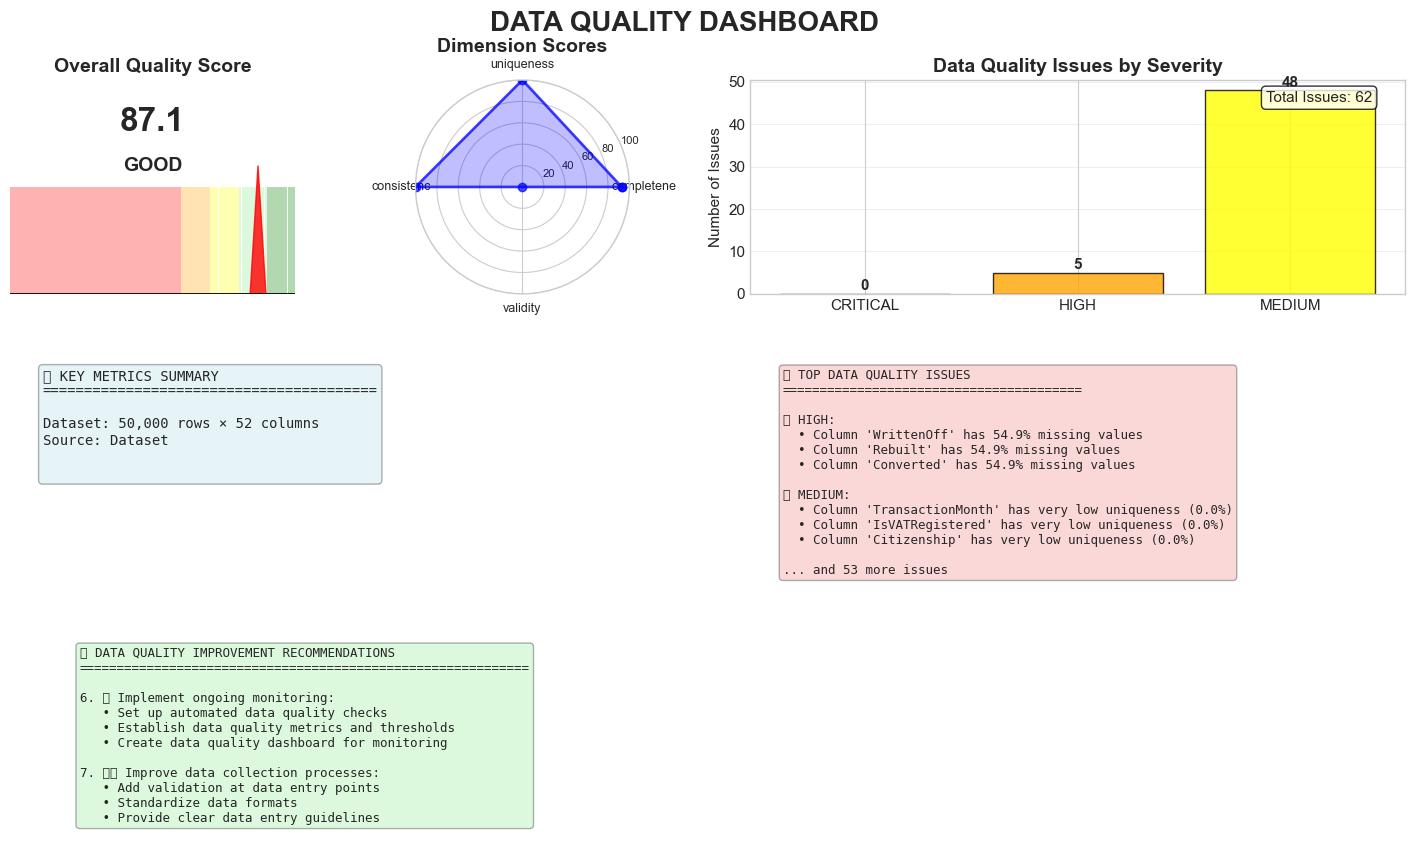

In [10]:
# Cell 10: Data Quality Dashboard
print("="*80)
print("📊 DATA QUALITY DASHBOARD")
print("="*80)

# Create comprehensive dashboard
fig = plt.figure(figsize=(18, 10))
fig.suptitle('DATA QUALITY DASHBOARD', fontsize=20, fontweight='bold', y=0.95)

# Create grid layout
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# 1. Overall Quality Score (Gauge Chart)
ax1 = fig.add_subplot(gs[0, 0])
score = metrics['quality_score']['overall_score']
rating = metrics['quality_score']['rating']

# Create simple gauge
angles = np.linspace(0, 180, 100)
values = np.linspace(0, 100, 100)
colors = []
for val in values:
    if val < 60:
        colors.append('red')
    elif val < 70:
        colors.append('orange')
    elif val < 80:
        colors.append('yellow')
    elif val < 90:
        colors.append('lightgreen')
    else:
        colors.append('green')

ax1.bar(angles, np.ones_like(angles)*0.5, width=1.8, bottom=0, color=colors, alpha=0.3)
ax1.plot([0, 180], [0, 0], color='black', linewidth=2)

# Add pointer
pointer_angle = 180 * score / 100
x = [pointer_angle - 5, pointer_angle, pointer_angle + 5]
y = [0, 0.6, 0]
ax1.fill(x, y, color='red', alpha=0.8)

# Add score text
ax1.text(90, 0.8, f'{score:.1f}', ha='center', va='center', fontsize=24, fontweight='bold')
ax1.text(90, 0.6, rating, ha='center', va='center', fontsize=14, fontweight='bold')

ax1.set_xlim(0, 180)
ax1.set_ylim(0, 1)
ax1.axis('off')
ax1.set_title('Overall Quality Score', fontsize=14, fontweight='bold')

# 2. Dimension Scores Radar Chart
ax2 = fig.add_subplot(gs[0, 1], projection='polar')
dimensions = list(metrics['quality_score']['dimension_scores'].keys())
scores = list(metrics['quality_score']['dimension_scores'].values())

# Close the polygon
angles = np.linspace(0, 2*np.pi, len(dimensions), endpoint=False).tolist()
angles += angles[:1]
scores += scores[:1]
dimensions_display = [d[:10] for d in dimensions] + [dimensions[0][:10]]

ax2.plot(angles, scores, 'o-', linewidth=2, color='blue', alpha=0.7)
ax2.fill(angles, scores, alpha=0.25, color='blue')
ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(dimensions_display[:-1], fontsize=9)
ax2.set_ylim(0, 100)
ax2.set_yticks([20, 40, 60, 80, 100])
ax2.set_yticklabels(['20', '40', '60', '80', '100'], fontsize=8)
ax2.grid(True)
ax2.set_title('Dimension Scores', fontsize=14, fontweight='bold', pad=20)

# 3. Issues by Severity
ax3 = fig.add_subplot(gs[0, 2:])
if analyzer.issues:
    # Categorize issues by severity
    severity_counts = {'CRITICAL': 0, 'HIGH': 0, 'MEDIUM': 0}
    for severity, _ in analyzer.issues:
        if severity in severity_counts:
            severity_counts[severity] += 1
    
    labels = list(severity_counts.keys())
    counts = list(severity_counts.values())
    colors = ['red', 'orange', 'yellow']
    
    bars = ax3.bar(labels, counts, color=colors, edgecolor='black', alpha=0.8)
    ax3.set_ylabel('Number of Issues')
    ax3.set_title('Data Quality Issues by Severity', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{count}', ha='center', va='bottom', fontweight='bold')
    
    # Add total issues
    ax3.text(0.95, 0.95, f'Total Issues: {len(analyzer.issues)}', 
            transform=ax3.transAxes, ha='right', va='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
else:
    ax3.text(0.5, 0.5, 'No Issues Found\n✅ Excellent Data Quality', 
            ha='center', va='center', fontsize=14, fontweight='bold', color='green')
    ax3.axis('off')

# 4. Key Metrics Summary
ax4 = fig.add_subplot(gs[1, :2])
ax4.axis('off')

summary_text = "📊 KEY METRICS SUMMARY\n" + "="*40 + "\n\n"

# Dataset info
summary_text += f"Dataset: {df.shape[0]:,} rows × {df.shape[1]} columns\n"
summary_text += f"Source: {source_name}\n\n"

# Missing data
if 'completeness' in metrics:
    comp = metrics['completeness']
    summary_text += f"Missing Values: {comp['missing_total']:,} ({comp['missing_pct']:.1f}%)\n"
    summary_text += f"Columns with Missing: {comp['cols_with_missing']}\n"
    summary_text += f"Rows with Missing: {comp['rows_with_missing']:,}\n\n"

# Duplicates
if 'uniqueness' in metrics:
    uniq = metrics['uniqueness']
    summary_text += f"Exact Duplicates: {uniq['exact_duplicates']:,} ({uniq['exact_duplicates_pct']:.1f}%)\n"
    summary_text += f"Low Cardinality Columns: {len(uniq['low_cardinality_cols'])}\n\n"

# Validity
if 'validity' in metrics:
    valid = metrics['validity']
    total_violations = len(valid.get('type_issues', [])) + len(valid.get('business_rule_violations', []))
    summary_text += f"Validity Issues: {total_violations}\n\n"

# Outliers
if 'accuracy' in metrics and 'outliers_summary' in metrics['accuracy']:
    outliers_data = metrics['accuracy']['outliers_summary']
    if outliers_data:
        total_outliers = sum([data['outlier_count'] for data in outliers_data.values()])
        summary_text += f"Total Outliers: {total_outliers:,}\n"
        summary_text += f"Critical Outlier Columns: {len(metrics['accuracy'].get('critical_outliers', []))}"

ax4.text(0.05, 0.95, summary_text, fontsize=10, fontfamily='monospace',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

# 5. Top Issues
ax5 = fig.add_subplot(gs[1, 2:])
ax5.axis('off')

if analyzer.issues:
    issues_text = "🚨 TOP DATA QUALITY ISSUES\n" + "="*40 + "\n\n"
    
    # Group issues by severity
    critical_issues = [(sev, issue) for sev, issue in analyzer.issues if sev == 'CRITICAL']
    high_issues = [(sev, issue) for sev, issue in analyzer.issues if sev == 'HIGH']
    medium_issues = [(sev, issue) for sev, issue in analyzer.issues if sev == 'MEDIUM']
    
    if critical_issues:
        issues_text += "🔴 CRITICAL:\n"
        for sev, issue in critical_issues[:3]:
            issues_text += f"  • {issue}\n"
        issues_text += "\n"
    
    if high_issues:
        issues_text += "🟠 HIGH:\n"
        for sev, issue in high_issues[:3]:
            issues_text += f"  • {issue}\n"
        issues_text += "\n"
    
    if medium_issues:
        issues_text += "🟡 MEDIUM:\n"
        for sev, issue in medium_issues[:3]:
            issues_text += f"  • {issue}\n"
    
    if len(analyzer.issues) > 9:
        issues_text += f"\n... and {len(analyzer.issues) - 9} more issues"
    
    ax5.text(0.05, 0.95, issues_text, fontsize=9, fontfamily='monospace',
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.3))
else:
    ax5.text(0.5, 0.5, '✅ No Data Quality Issues Found\nExcellent Data Quality!', 
            ha='center', va='center', fontsize=12, fontweight='bold', color='green')

# 6. Recommendations
ax6 = fig.add_subplot(gs[2, :])
ax6.axis('off')

recommendations = "📋 DATA QUALITY IMPROVEMENT RECOMMENDATIONS\n" + "="*60 + "\n\n"

# Based on analysis results
if 'completeness' in metrics:
    comp = metrics['completeness']
    if comp['missing_pct'] > 10:
        recommendations += "1. 🔍 Address high missing values (>10%):\n"
        recommendations += "   • Implement imputation strategies\n"
        recommendations += "   • Investigate root causes of missing data\n"
        recommendations += "   • Consider dropping columns with >50% missing\n\n"
    
    if comp['rows_with_missing'] > len(df) * 0.3:
        recommendations += "2. 📝 Handle rows with missing data:\n"
        recommendations += "   • Impute missing values using appropriate methods\n"
        recommendations += "   • Consider removing rows with excessive missing values\n\n"

if 'uniqueness' in metrics:
    uniq = metrics['uniqueness']
    if uniq['exact_duplicates'] > 0:
        recommendations += "3. 🧹 Remove duplicate records:\n"
        recommendations += "   • Identify and remove exact duplicates\n"
        recommendations += "   • Investigate business duplicate scenarios\n\n"

if 'validity' in metrics:
    valid = metrics['validity']
    if valid.get('business_rule_violations'):
        recommendations += "4. ✅ Fix business rule violations:\n"
        recommendations += "   • Correct negative premium/claim values\n"
        recommendations += "   • Validate date ranges\n"
        recommendations += "   • Fix data type inconsistencies\n\n"

if 'accuracy' in metrics:
    accuracy = metrics['accuracy']
    if accuracy.get('critical_outliers'):
        recommendations += "5. 🎯 Handle outliers:\n"
        recommendations += "   • Investigate extreme values\n"
        recommendations += "   • Apply appropriate outlier treatment methods\n"
        recommendations += "   • Consider winsorization or truncation\n\n"

# General recommendations
recommendations += "6. 📊 Implement ongoing monitoring:\n"
recommendations += "   • Set up automated data quality checks\n"
recommendations += "   • Establish data quality metrics and thresholds\n"
recommendations += "   • Create data quality dashboard for monitoring\n\n"

recommendations += "7. 🏗️ Improve data collection processes:\n"
recommendations += "   • Add validation at data entry points\n"
recommendations += "   • Standardize data formats\n"
recommendations += "   • Provide clear data entry guidelines"

ax6.text(0.05, 0.95, recommendations, fontsize=9, fontfamily='monospace',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))

plt.tight_layout()
plt.show()

In [11]:
# Cell 11: Generate Compact Data Quality Report
print("="*80)
print("💾 SAVING COMPACT DATA QUALITY REPORT")
print("="*80)

import json
import pandas as pd
from pathlib import Path
import os

# Create reports directory
reports_dir = Path("reports")
reports_dir.mkdir(exist_ok=True)

# Get timestamp without microseconds for smaller string
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

# Create compact report
report = {
    # Basic info
    't': timestamp,
    'ds': source_name if 'source_name' in locals() else 'unknown',
    'r': int(df.shape[0]),
    'c': int(df.shape[1]),
    
    # Quality scores
    'qs': {
        'o': round(metrics['quality_score']['overall_score'], 1),
        'r': metrics['quality_score']['rating'],
        'd': {k: round(v, 1) for k, v in metrics['quality_score']['dimension_scores'].items()}
    },
    
    # Issue counts only (not full messages to save space)
    'ic': {
        'C': len([i for i in analyzer.issues if i[0] == 'CRITICAL']),
        'H': len([i for i in analyzer.issues if i[0] == 'HIGH']),
        'M': len([i for i in analyzer.issues if i[0] == 'MEDIUM']),
        'L': len([i for i in analyzer.issues if i[0] == 'LOW']),
        'I': len([i for i in analyzer.issues if i[0] == 'INFO']),
        'T': len(analyzer.issues)
    },
    
    # Key metrics only (most important ones)
    'km': {
        'mc': int(metrics['metrics']['completeness']['missing_cells']),
        'mp': round(100 - metrics['metrics']['completeness']['overall_completeness'], 1),
        'dr': int(metrics['metrics']['uniqueness']['duplicate_rows']),
        'dp': round(metrics['metrics']['uniqueness']['duplicate_pct'], 1)
    }
}

# Save compact JSON (no indentation, minimal whitespace)
report_path = reports_dir / f"dq_report_{timestamp}.json"
with open(report_path, 'w') as f:
    json.dump(report, f, separators=(',', ':'))
print(f"✅ JSON report: {report_path} ({os.path.getsize(report_path)/1024:.1f} KB)")

# Save only top missing columns (not all columns)
if 'missing_summary' in locals():
    # Take top 20 columns with most missing values
    missing_top = missing_summary.nlargest(20, 'missing_pct')[['column', 'missing_pct']]
    missing_csv = reports_dir / f"missing_top_{timestamp}.csv"
    missing_top.to_csv(missing_csv, index=False)
    print(f"✅ Missing summary: {missing_csv}")
else:
    # Create minimal missing summary
    missing_data = []
    for col in df.columns:
        missing_pct = (df[col].isnull().sum() / len(df)) * 100
        if missing_pct > 1:  # Only save columns with >1% missing
            missing_data.append([col, missing_pct])
    
    if missing_data:
        missing_df = pd.DataFrame(missing_data, columns=['column', 'missing_pct'])
        missing_csv = reports_dir / f"missing_issues_{timestamp}.csv"
        missing_df.to_csv(missing_csv, index=False)
        print(f"✅ Missing issues: {missing_csv}")
    else:
        print("✅ No significant missing values to report")

# Save dashboard figure with lower DPI if it exists
if 'plt' in locals() and 'dashboard_path' in locals():
    try:
        figures_dir = reports_dir / "figures"
        figures_dir.mkdir(exist_ok=True)
        dashboard_path = figures_dir / f"dashboard_{timestamp}.jpg"  # JPG is smaller than PNG
        plt.savefig(dashboard_path, dpi=150, bbox_inches='tight', format='jpg', quality=85)
        print(f"✅ Dashboard: {dashboard_path} ({os.path.getsize(dashboard_path)/1024:.1f} KB)")
    except:
        print("⚠️ Could not save dashboard figure")

print("\n" + "="*80)
print("✅ DATA QUALITY ASSESSMENT COMPLETE")
print("="*80)

# Compact final summary
print(f"\n📊 SUMMARY:")
print(f"• Quality: {report['qs']['o']}/100 ({report['qs']['r']})")
print(f"• Missing: {report['km']['mc']:,} cells ({report['km']['mp']}%)")
print(f"• Duplicates: {report['km']['dr']:,} rows ({report['km']['dp']}%)")
print(f"• Issues: {report['ic']['T']} total")

if report['ic']['C'] > 0 or report['ic']['H'] > 0:
    print(f"🚨 PRIORITY: {report['ic']['C']} critical, {report['ic']['H']} high issues")

# Show top 3 issues only
print(f"\n🔝 TOP ISSUES:")
top_issues_shown = 0
for severity in ['CRITICAL', 'HIGH', 'MEDIUM']:
    for sev, issue in analyzer.issues:
        if sev == severity and top_issues_shown < 3:
            # Truncate long issue messages
            if len(issue) > 100:
                issue = issue[:97] + "..."
            print(f"  {severity[0]}: {issue}")
            top_issues_shown += 1
        if top_issues_shown >= 3:
            break
    if top_issues_shown >= 3:
        break

print(f"\n📁 OUTPUTS:")
print(f"  • {report_path.name} (JSON report)")
if 'missing_csv' in locals():
    print(f"  • {missing_csv.name} (missing data)")
if 'dashboard_path' in locals():
    print(f"  • {dashboard_path.name} (visual)")

print(f"\n🎯 NEXT:")
if report['qs']['o'] >= 70:
    print("  Data is ready → Proceed to univariate analysis")
else:
    print("  Clean data first → Address top issues above")

print("\n" + "="*80)

💾 SAVING COMPACT DATA QUALITY REPORT
✅ JSON report: reports\dq_report_20251209_1452.json (0.2 KB)
✅ Missing issues: reports\missing_issues_20251209_1452.csv

✅ DATA QUALITY ASSESSMENT COMPLETE

📊 SUMMARY:
• Quality: 87.1/100 (GOOD)
• Missing: 187,229 cells (7.2%)
• Duplicates: 0 rows (0.0%)
• Issues: 62 total
🚨 PRIORITY: 0 critical, 5 high issues

🔝 TOP ISSUES:
  H: Column 'WrittenOff' has 54.9% missing values
  H: Column 'Rebuilt' has 54.9% missing values
  H: Column 'Converted' has 54.9% missing values

📁 OUTPUTS:
  • dq_report_20251209_1452.json (JSON report)
  • missing_issues_20251209_1452.csv (missing data)

🎯 NEXT:
  Data is ready → Proceed to univariate analysis

